 - Classification / multivariate classification for the MNIST dataset
 - Precision/Recall as metrics

In [1]:
# imports
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(42)

import sklearn
assert sklearn.__version__ >= "0.20"

In [2]:
# fetch dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

Let's separate the training set from the labels:

In [7]:
# arrays
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

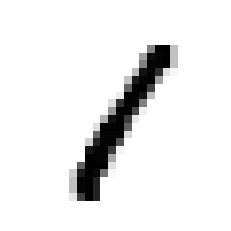

In [9]:
digit = X[3] # check an image
digit_img = digit.reshape(28, 28) 

plt.imshow(digit_img, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis('off')
plt.show()

In [10]:
# image label
y[3]

'1'

In [11]:
# convert labels into integers
y = y.astype(np.uint8)

##### Set test set aside

As per sklearn datasets, training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be similar.

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 1. Training a binary classifier

First, we'll simplify the problem. Inthis part we'll just try to identify one number. Let's create target vectors for this classification task.

In [8]:
y_train_5 = (y_train == 5) # True for all 5s, False for the rest of digits
y_test_5 = (y_test == 5)

Stochastic Gradient Descent (SGD) classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning).

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([digit])

array([ True])

## 2. Performance measures

###### Cross-Validation
At each iteration the code will create a clone of the classifier, train that clone on the training folds, and make predictions on the test fold. Then it'll count the number of correct predictions and outputs the ratio of correct predictions.

In [11]:
# from scratch
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [12]:
# cross-validation 
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

##### A simple classifier for "not 5s"

In [13]:
from sklearn.base import BaseEstimator


class NotFive(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never5 = NotFive()
cross_val_score(never5, X_train, y_train_5, cv=3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

Such high score is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets.

##### Confusion Matrix

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that we get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

##### Precision and recall

- Acc = TP / Total 
- Prec = TP / TP + FP (cost of FP is high, spam detect)
- Rec = TP / TP + FN (cost of FN is high, medical)

In [17]:
from sklearn.metrics import precision_score, recall_score

print('Precision:', precision_score(y_train_5, y_train_pred))
print('Recall:', recall_score(y_train_5, y_train_pred))

Precision: 0.8370879772350012
Recall: 0.6511713705958311


When this simple classifier claims an image represents a 5, it's correct 83.7% of the time.
It only detects 5s 65% of the time.

##### F1 score

F1 score is the harmonic mean of precision and recall. Whereas a regular mean would treat all values equally, an harmonic mean gives more weight to low values. As a result, we'll only get a high F1 score if both precision and recall have high values.

In [18]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

##### Precision and recall tradeoff

SGDClassifier makes its classification decisions by computing a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class; lowering the threshold increases recall and reduces precision.

Instead of calling the classifier’s predict() method, we can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold we want.



In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function')

Now with these scores we can compute precision and recall for all possible thresholds using the precision_recall_curve() function.

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

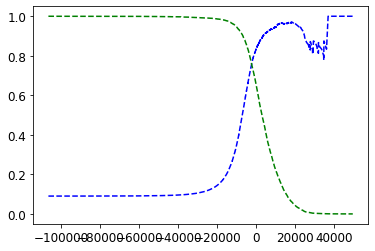

In [21]:
def plot_prec_recal_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')
    
plot_prec_recal_threshold(precisions, recalls, thresholds)
plt.show()

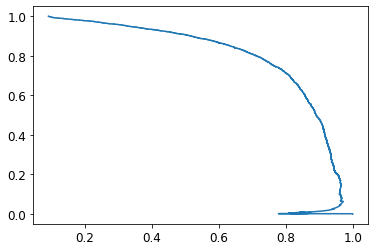

In [22]:
# just precision and recall
plt.plot(precisions, recalls)

We can see that precision really starts to fall sharply around 80% recall. We will probably want to select a precision/recall tradeoff just before that drop.

##### ROC curve

It's similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate. So, ROC curve plots sensitivity (recall) versus 1 – specificity.

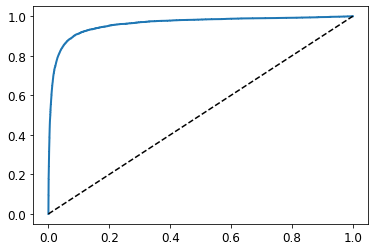

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def ROC_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    
ROC_curve(fpr, tpr)
plt.show()
    

In [24]:
# area under curve
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier. First, we need to get scores for each instance in the training set. But due to the way it works the RandomForestClassifier class does not have a decision_function() method. Instead it has a predict_proba() method, which returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class 

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                 method='predict_proba')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


To plot a ROC curve we need scores, not probabilities. A simple solution is to
use the positive class’s probability as the score.

In [26]:
y_scores_forest = y_prob_forest[:, 1] # score = probs of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

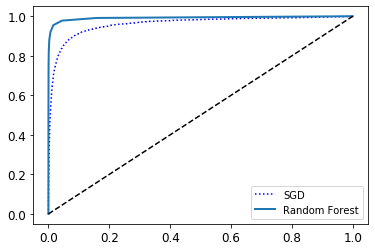

In [27]:
plt.plot(fpr, tpr, 'b:', label='SGD')
ROC_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s. As a result, its ROC AUC score is also significantly better:

In [28]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

## 3. Multiclass classification

In [37]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([digit])

array([3], dtype=uint8)

Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score (wrong in this case!)

In [38]:
# let's see those probabilities
digit_scores = sgd_clf.decision_function([digit])
digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [39]:
print(np.argmax(digit_scores))
print(sgd_clf.classes_)

3
[0 1 2 3 4 5 6 7 8 9]


In [40]:
# let's force the classifier for an one versus one strategy
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([digit])

array([5], dtype=uint8)

In [41]:
len(ovo_clf.estimators_)

45

In [42]:
# evaluating the classifier
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87082583, 0.87089354, 0.88628294])

Above 87%

In [43]:
# scaling the inputs for better accuracy
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

Above 89%

## 4. Error Analysis

In [44]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
cm1 = confusion_matrix(y_train, y_train_pred)
cm1

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]])

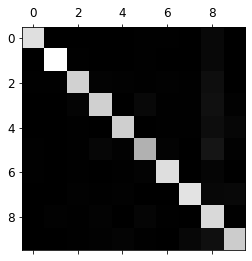

In [45]:
plt.matshow(cm1, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks fairly good, since most images are on the main diagonal, which means that they were classified correctly. The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. In fact, we can verify that both are the case.

Let’s focus the plot on the errors. First, we need to divide each value in the confusion matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors.

In [46]:
row_sums = cm1.sum(axis=1, keepdims=True)
norm_cm1 = cm1 / row_sums

Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result.

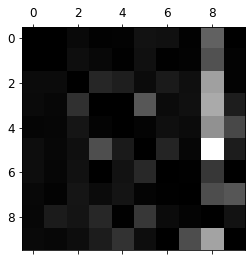

In [47]:
np.fill_diagonal(norm_cm1, 0)
plt.matshow(norm_cm1, cmap=plt.cm.gray) 
plt.show()

The column for class 8 is quite bright, which tells us that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling us that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical. You can also see that 3s and 5s often get confused (in both directions).

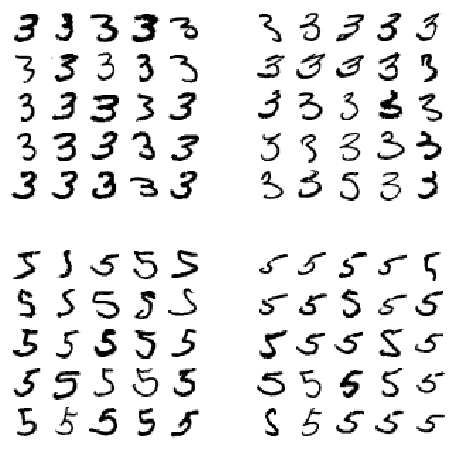

In [48]:
# let's see those 3s and 5s
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    


cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] 
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] 
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] 
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5) 
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5) 
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5) 
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5) 
plt.show()

The two 5×5 blocks on the left show digits classified as 3s, and the two 5×5 blocks on the right show images classified as 5s. 

The reason for those misclassified digits (top right and bottom left, as in a confusion matrix) that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them.

## 4. Multilabel classification

Code will create a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8, or 9) and the second indicates whether or not it is odd. The next lines create a KNeighborsClassifier instance (which supports multilabel classification, but not all classifiers do) and we train it using the multiple targets array. 

In [50]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Now we can make a prediction, and notice that it outputs two labels.

In [51]:
knn_clf.predict([digit])
# The digit 5 is indeed not large (False) and odd (True).

array([[False,  True]])

Now, this next code computes the average F1 score across all labels.

In [52]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

Code above assumes that all labels are equally important, but another option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, we set average="weighted" in the preceding code.

In [53]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9778357403921755

## 5. Multioutput classification

To build a generalization of multilabel classification where each label can be multiclass, first we'll build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, repre‐ sented as an array of pixel intensities, just like the MNIST images.

We begin by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities using NumPy’s randint() function. The target images will be the original images.

In [55]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

Now let’s train the classifier and make it clean the image.

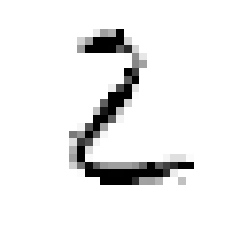

In [58]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[1]])
plot_digits(clean_digit)